In [ ]:
# Installing depenencies [ Only do it once, if u don't have these libraries installed already ]
!pip install easyocr
!pip install imutils

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import imutils
import easyocr
import cv2
import re 

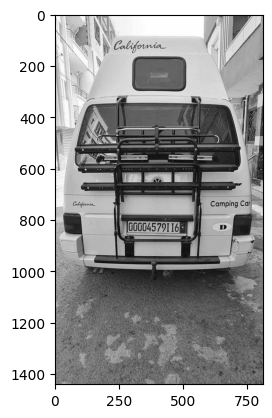

In [97]:
CAR_IMAGE_NAME = 'loc5.jpg'
image = cv2.imread('dataset/yes/'+CAR_IMAGE_NAME)
grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # CV2 reads images in BGR (Blue/Green/Red), we convert it to gray
plt.imshow(cv2.cvtColor(grey, cv2.COLOR_BGR2RGB)) # pyplot requires images in RGB to properly display images

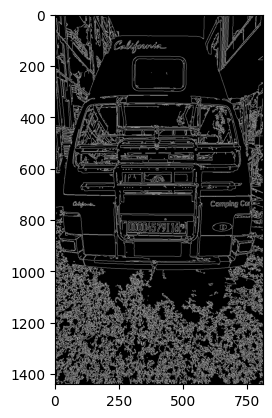

In [98]:
# Applying filter to then find edges
filtered = cv2.bilateralFilter(grey, 11, 17, 17) # Bilateral filter to reduce noise 11 17 17
edged = cv2.Canny(filtered, 10, 200) # Canny algorithm to detect edges 
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

In [99]:
# Finding contours to apply mask
key_points = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
'''
RETR_TREE: display as a tree; 
CHAIN_APPROX_SIMPLE: to return the countours in a simplified way, ideally 4 points
'''
contours = imutils.grab_contours(key_points)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10] # sort top 10 countours by area in a descending way

In [100]:
location = []
k = 4
while k<=20:
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 10, True)
        if len(approx) == k:
            location.append(approx)
    k+=1

len(location)

9

In [101]:
def mask_crop(grey, location, LOC, image):
    mask = np.zeros(grey.shape, np.uint8) # Black mask same size as our image
    plate_image = cv2.drawContours(mask, [location[LOC]], 0, 255, -1)
    plate_image = cv2.bitwise_and(image, image, mask=mask)
    plt.imshow(cv2.cvtColor(plate_image, cv2.COLOR_BGR2RGB))

    # Cropping the plate to pass it to easyOCR Reader:
    (x, y) = np.where(mask == 255)
    (x1, y1) = (np.min(x), np.min(y))
    (x2, y2) = (np.max(x), np.max(y))
    plate_cropped = grey[x1:x2+1, y1:y2+1]
    plt.imshow(cv2.cvtColor(plate_cropped, cv2.COLOR_BGR2RGB))
    
    return plate_image, plate_cropped

def read_plate(plate_cropped):
    # Reading the plate number
    reader = easyocr.Reader(['en'])
    result_rec = reader.recognize(plate_cropped)
    result_red = reader.readtext(plate_cropped)
    nc = len(result_rec)
    nd = len(result_red)
    
    return result_rec, result_red, nc, nd

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


location[1] is possibly a plate
location[5] is possibly a plate


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Before changes:
00004579416]
[00004579116

After changes:
['00004579416']
['00004579116']


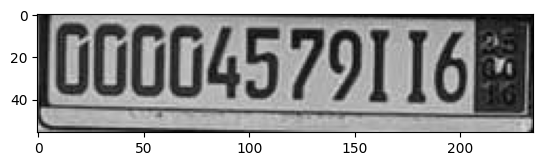

In [103]:
# custom function to try and check if we selected the right conour that represents a number plate and not something else
cpr = 0
LOC = 0 # location value by default we try 0, we change if possible later whithin the code
potential_plates = [] # empty list to hold potential plates calculated by this function:
for i, loc in enumerate(location):
    x1 = loc[0][0][1]
    x2 = loc[1][0][1]
    y3 = loc[2][0][0]
    y2 = loc[1][0][0] 
    
    h = x2 - x1
    w = y3 - y2
    
    if w > 110 and w < 300 and h > 23 and h < 70:
        print("location["+str(i)+"] is possibly a plate")
        potential_plates.append(i)
        cpr+=1
if cpr == 0:
    print("No plate detected :(")

    
# mask = np.zeros(grey.shape, np.uint8) # Black mask same size as our image
# plate_image = cv2.drawContours(mask, [location[LOC]], 0, 255, -1)
# plate_image = cv2.bitwise_and(image, image, mask=mask)
# plt.imshow(cv2.cvtColor(plate_image, cv2.COLOR_BGR2RGB))

# # Cropping the plate to pass it to easyOCR Reader:
# (x, y) = np.where(mask == 255)
# (x1, y1) = (np.min(x), np.min(y))
# (x2, y2) = (np.max(x), np.max(y))
# plate_cropped = grey[x1:x2+1, y1:y2+1]
# plt.imshow(cv2.cvtColor(plate_cropped, cv2.COLOR_BGR2RGB))

plate_image, plate_cropped = mask_crop(grey, location, LOC, image)



# # Reading the plate number
# reader = easyocr.Reader(['en'])
# result_rec = reader.recognize(plate_cropped)
# result_red = reader.readtext(plate_cropped)
result_rec, result_red, nc, nd = read_plate(plate_cropped)


is_plate = True
if nc == 0 or nd == 0: # we detected something thats not a plate
    is_plate = False
    for i in range(len(potential_plates)):
        LOC = potential_plates[i]
        plate_image, plate_cropped = mask_crop(grey, location, LOC, image)
        result_rec, result_red, nc, nd = read_plate(plate_cropped)
        if nc == 0 or nd == 0:
            continue
        else:
            is_plate = True
            break
if is_plate:
    print("Before changes:")
    print(result_rec[0][-2])
    print(result_red[0][-2]+"\n")

    rec = re.findall(r'\d+', result_rec[0][-2])
    red = re.findall(r'\d+', result_red[0][-2])
    print('After changes:')
    print(rec)
    print(red)
else:
    raise UserWarning('No plate detected Sadly, please select another image and try again')


In [104]:
# mask = np.zeros(grey.shape, np.uint8) # Black mask same size as our image
# plate_image = cv2.drawContours(mask, [location[0]], 0, 255, -1)
# plate_image = cv2.bitwise_and(image, image, mask=mask)
# plt.imshow(cv2.cvtColor(plate_image, cv2.COLOR_BGR2RGB))

In [105]:
# (x, y) = np.where(mask == 255)
# (x1, y1) = (np.min(x), np.min(y))
# (x2, y2) = (np.max(x), np.max(y))
# plate_cropped = grey[x1:x2+1, y1:y2+1]
# plt.imshow(cv2.cvtColor(plate_cropped, cv2.COLOR_BGR2RGB))

In [106]:
# reader = easyocr.Reader(['en'])
# result_rec = reader.recognize(plate_cropped)
# result_red = reader.readtext(plate_cropped)
# print("Before changes:")
# print(result_rec[0][-2])
# print(result_red[0][-2]+"\n")

# rec = re.findall(r'\d+', result_rec[0][-2])
# red = re.findall(r'\d+', result_red[0][-2])
# print('After changes:')
# print(rec)
# print(red)

## Result processing 

In [107]:
#helper function to store license plate values after processing 
def record(a, b, c):
    new_list = [0, 0, 0]
    
    new_list[0]= a
    new_list[1]= b
    new_list[2]= c
    
    return new_list

In [108]:
# TODO: algo to select one result between rec and red 
processed_plate_number = [0,0,0] # List to hold values for the plate after being processed
rec_n = len(rec)
red_n = len(red)

if red_n == 3:
    red_a = red[0]
    red_b = red[1]
    red_c = red[2]
    
    if len(red_a) <=6 and (len(red_b) == 3 or red_b == "00") and int(red_c) > 0 and int(red_c) < 59:
        pass
    elif len(red_a) > 6 and rec_n == 3 and len(rec[0])<=6: 
        red_a = rec[0]
    elif len(red_b) < 3 and rec_n == 3 : 
        red_b = rec[1]
    
    processed_plate_number = record(red_a, red_b, red_c) # serial, type, wilaya


elif red_n == 2:
    red_a = red[0]
    red_b = red[1]
    if rec_n == 3:
        rec_a = rec[0]
        rec_b = rec[1]
        rec_c = rec[2]
        if len(red_a) <= 6 and (len(red_b) == 3 or red_b == "00"): # read text detected serial + type
            processed_plate_number = record(red_a, red_b, rec_c)
            
        elif (len(red_a) == 3 or red_a == "00") and int(red_b) > 0 and int(red_b) < 59: # read text type + wilaya
            processed_plate_number = record(rec_a, red_a, red_b)
        
        elif len(rec_a) <=6 and (len(rec_b) == 3 or rec_b == "00") and int(rec_c) > 0 and int(rec_c) < 59: 
            processed_plate_number = record(rec_a, rec_b, rec_c)
            
            
        
    elif rec_n == 2: # both functions gave 2 values when usually one of the two contains 2 concatenated values
        rec_a = rec[0]
        rec_b = rec[1]
        if len(red_b) == 2 and (len(red_a) == 8 or len(red_a) == 9): # serial+type are concatenated, wilaya is red_b 
            processed_plate_number = record(red_a[:-3], red_a[-3:], red_b)
            
        elif len(red_b) == 5 and (len(red_a) == 5 or len(red_a) == 6): # serial is red_a, type+wilaya are concatenated
            processed_plate_number = record(red_a, red_b[:-2], red_b[-2:])
    
    
    
    
    
    elif rec_n == 1 and (len(rec[0]) == 10 or len(rec[0]) == 11):
        rec_a = rec[0]
        if len(red_b) == 2: # type + wilaya and rec_a has the full plate number
            processed_plate_number = record(rec_a[:-5], red_a, red_b)
            
        elif len(red_b) == 3: #serial + type
            processed_plate_number = record(red_a, red_b, rec_a[-2:])
    
    else: # nchlh wilaya tkoun hiya telya; case te3 car09
        rec_a = rec[-1] # grabbing the wilaya
        if len(red_b) == 3: #serial + type
            processed_plate_number = record(red_a, red_b, rec_a)
            
            
            
elif red_n == 1:
    red_a = red[0]
    if rec_n == 3:
        rec_a = rec[0]
        rec_b = rec[1]
        rec_c = rec[2]
        if len(rec_a) <=6 and (len(rec_b) == 3 or rec_b == "00") and int(rec_c) > 0 and int(rec_c) < 59:
            processed_plate_number = record(rec_c, rec_b, rec_a)
            
    elif len(red_a) == 10 or len(red_a) == 11:
        processed_plate_number = record(red[0][:-5], red[0][-5:-2], red[0][-2:])
#         processed_plate_number[2] = red[0][-2:]    # wilaya
#         processed_plate_number[1] = red[0][-5:-2]  # type+year
#         processed_plate_number[0] = red[0][:-5]    # 5 or 6 digits for the actual vehicle serial number
        
    elif (len(red_a) == 5 or len(red_a) == 6) and rec_n == 1 and len(rec[0])>=10:
        processed_plate_number = record(red_a, rec[0][-5:-2], rec[0][-2:])
    
    elif (len(red_a) == 8 or len(red_a) == 9) and rec_n == 1 and len(rec[0])>=10:
        processed_plate_number = record(red_a[:-3], red_a[-3:], rec[0][-2:])
        
    elif (len(red_a) == 8 or len(red_a) == 9) and rec_n == 2 and int(rec[1]) > 0 and int(rec[1]) < 59:
        processed_plate_number = record(red_a[:-3], red_a[-3:], rec[1])
        
        
try:
    if sum(processed_plate_number):
        print("Error")
except:
    print("Final result? ")
    print(processed_plate_number)

Final result? 
['000045', '791', '16']


## Extracting information from plate number

In [109]:
# EX: 23153 118 31
result = processed_plate_number
current_year = int(str(datetime.date.today().year)[-2:]) # for 2023 it returns 23
car_class_types = ["Private Vehicle","Truck","Van","Bus","Road tractor","Non-Road Tractor","Special vehicle","Trailer","Motorcycle"]
algerian_wilayas = ["Adrar", "Chlef", "Laghouat", "Oum El Bouaghi", "Batna", "Béjaïa", "Biskra", "Béchar", "Blida", "Bouïra", "Tamanrasset", "Tébessa", "Tlemcen", "Tiaret", "Tizi Ouzou", "Algiers", "Djelfa", "Jijel", "Sétif", "Saïda", "Skikda", "Sidi Bel Abbès", "Annaba", "Guelma", "Constantine", "Médéa", "Mostaganem", "M'Sila", "Mascara", "Ouargla", "Oran", "El Bayadh", "Illizi", "Bordj Bou Arréridj", "Boumerdès", "El Tarf", "Tindouf", "Tissemsilt", "El Oued", "Khenchela", "Souk Ahras", "Tipaza", "Mila", "Aïn Defla", "Naâma", "Aïn Témouchent", "Ghardaïa", "Relizane", "El M'Ghair", "El Menia", "Ouled Djellal", "Bordj Baji Mokhtar", "Béni Abbès", "Timimoun", "Touggourt", "Djanet", "In Salah", "In Guezzam"]

car_serial = result[0]                            # 23153
car_class = car_class_types[int(result[1][0])-1]  # 1 returns 'Private Vehicles'
car_year = int(result[1][-2:])                    # 18 returns 2018
wilaya = algerian_wilayas[int(result[2])-1]       # 31 returns 'Oran'


if car_year != 33:
    if car_year > current_year:
        car_year+= 1900
    else:
        car_year+= 2000
else:
    car_year = "Unknown year of manufacture"

print("This plate indicates:\nCar class type  : "+car_class+"\nSerial Number\t: "+car_serial+"\nManufactured in : "+str(car_year)+"\nRegistered in\t: "+wilaya+" "+result[2])

This plate indicates:
Car class type  : Special vehicle
Serial Number	: 000045
Manufactured in : 1991
Registered in	: Algiers 16


## Displaying the result

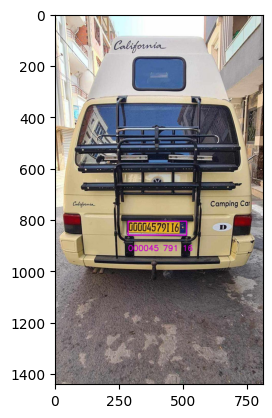

In [110]:
DETECTION_COLOR = (200,0,200) # Change the color here
approx = location[LOC]          # Coords
text = " ".join(result)       # Plate number into one string

font = cv2.FONT_HERSHEY_SCRIPT_SIMPLEX
res = cv2.putText(image, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=DETECTION_COLOR, thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(image, tuple(approx[0][0]), tuple(approx[2][0]), DETECTION_COLOR,3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

In [111]:
# Saving the image
extension = CAR_IMAGE_NAME[-4:]
cv2.imwrite('plates/'+text.replace(" ","_")+extension, res)

True